In [1]:
import numpy as np 
import pandas as pd 
import pyomo.environ as pyo
import geopandas as gpd
import matplotlib.pyplot as plt
import gurobipy

/home/ali_p/anaconda3/envs/py37_64/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
import random

In [3]:
tt_98 = pd.read_csv('travel_time/assignment_98.csv').set_index('Unnamed: 0')

tt_98.index.name = 'zone'

tt_98 = tt_98.iloc[:693,:693]

tt_98 = tt_98/60

In [4]:
data = pd.read_csv('shelter/dem_98.csv')
data['pop'] = data['pop']/10**3
data = data[['zone','pop']] 
data['zone'] = data['zone'].astype(np.str_)

## Scenario Generation
1. We assume that initially, `10` zones are hit by the hurricane.
2. Every neighboring zone within `10` minutes of travel time of the initially affected zones needs service.
3. `70 percent` of the population in each affected zone needs service.
4. In each scenario, approximately `80 zones` are affected, and approximately `700 thousand people` need service.  

In [5]:
scenarios = {i:[] for i in range(1,4)}

for i in scenarios.keys():

    locs = random.sample(range(1,693), 10)
    for loc in locs:
        scenarios[i].append(str(loc))
        neigbors = tt_98[tt_98[str(loc)]<10].index.tolist()
        for j in neigbors:
            scenarios[i].append(str(j))


    
            
demand_scenarios = {i:None for i in range(1,4)}
for i in demand_scenarios.keys():
    d = data[data['zone'].isin(scenarios[i])]
    demand_scenarios[i] = dict(zip(d['zone'], d['pop']*0.7))
            
demand = {i:0 for i in range(1,4)}
for i in demand_scenarios.keys():
    demand[i] = sum(demand_scenarios[i].values())
        
num = {i:0 for i in range(1,4)}
for i in scenarios.keys():
    num[i] = len(scenarios[i])
    
    
for i in scenarios.keys():
    scenarios[i] = list(map(int,scenarios[i]))
    scenarios[i].sort()

demand = {i:{} for i in range(1,4)}
for i in demand_scenarios.keys():
    for key, item in demand_scenarios[i].items():
        demand[i][int(key)]=item
        
for i in demand.keys():
    for j in range(1,694):
        if j not in demand[i].keys():
            demand[i][j]=0
            
demands = {}
for i in demand.keys():
    for j in demand[i].keys():
        demands[i,j] =  demand[i][j]

In [6]:
node_n_safe = {}
for i in scenarios.keys():
    for node in range(1,694):
        if node in scenarios[i]:
            node_n_safe[i,node] = 0
        else:
            node_n_safe[i,node] = 1

In [7]:
tt = tt_98.copy()
tt.columns = tt_98.columns.astype(np.int64)

In [8]:
od = {}
for i in tt.index:
    for j in tt.columns:
        od[i,j]= tt.loc[i,j]

## Model Formulation

### Assumptions
1. The propblem is formulated for three scenarios.
1. $P$ (maximum numbers of shelters can be located) : 50
2. $S$ (maximum numbers of shelters can be opened) : 20
3. $c_j$ (capacity of shelters (thousand people)) : 25 
4. $\gamma$ (assumed travel time for people not accommodated in shelters): 2.5 Hr

In [9]:
model = pyo.ConcreteModel('Two-Stage Stochastic')


######## 1. Sets 

# demand nodes 
model.I = pyo.RangeSet(1,693)

# candidate location for shelter
model.J = pyo.RangeSet(1,693)

# scenarios
model.L = pyo.RangeSet(1,3)

# demand nodes in scenarios 



######## 2. Decision variables 

# shelter locations
model.x = pyo.Var(model.J, within=pyo.Binary)

# open shelters 
model.w = pyo.Var(model.L, model.J, within=pyo.Binary)

# demand allocated from each node to each shelter 
model.y = pyo.Var(model.L, model.I, model.J, within=pyo.NonNegativeReals)

# unresponded demand from each node 
model.z = pyo.Var(model.L, model.I, within=pyo.NonNegativeReals)


###### 3. Parameters 

# maximum number of shelters to be located 
model.max_located = pyo.Param(initialize=50)

# maximum number of shelters to be opened 
model.max_opened = pyo.Param(initialize=20)

# capacity of shelters 
model.capacity = pyo.Param(initialize=25)

# demand in each scenario
model.demand = pyo.Param(model.L, model.I, initialize=demands)

# safe nodes in each scenario
model.safe_node = pyo.Param(model.L, model.J, initialize=node_n_safe)

# travel time 
model.tt = pyo.Param(model.I, model.J, initialize=od)

# scenarios' probability 
model.p = pyo.Param(model.L, initialize=0.5)

#  relative importance of travel time in comparison to the number of people not accommodated in shelters.
model.gamma = pyo.Param(initialize=150)


##### 4. Constraints 

# maximum number of shelters to be located 
model.cons_max_loc_shelters = pyo.Constraint(expr = sum(model.x[j] for j in model.J) <= model.max_located)

# maximum number of shelters to be opened 
def op_shelters(mdl, l):
    return sum(mdl.w[l,j] for j in mdl.J) <= model.max_opened
model.cons_max_op_shelters = pyo.Constraint(model.L, rule=op_shelters)

# opening shelters only at safe locations
def safe_shelter(mdl, l, j):
    return mdl.w[l,j] <= mdl.safe_node[l,j] * mdl.x[j]
model.cons_safe_shelters = pyo.Constraint(model.L, model.J, rule=safe_shelter)

# the total number of people accommodated in the shelter at site j under hurricane scenario l cannot exceed its capacity
def accom_shelter(mdl, l, j):
    return sum(mdl.y[l,i,j] for i in mdl.I) <= mdl.capacity * mdl.w[l,j]
model.cons_accom_shelters = pyo.Constraint(model.L, model.J, rule=accom_shelter)

# The total number of people from origin i allocated to shelters cannot exceed the total number of evacuees from origin i seeking to use sheltersunder this scenario.
def alloc_node(mdl, l, i):
    return sum(mdl.y[l,i,j] for j in mdl.J) <= mdl.demand[l,i]
model.cons_alloc_nodes = pyo.Constraint(model.L, model.I, rule=alloc_node)

# the number of evacuees from origin i who seek shelters in scenario l but cannot be accommodated.
def not_accom(mdl, l, i):
    return sum(mdl.y[l,i,j] for j in mdl.J) + mdl.z[l,i] == mdl.demand[l,i]
model.cons_not_accom = pyo.Constraint(model.L, model.I, rule=not_accom)


###### 5. Object function 
def obj_rule(mdl):
    return sum(mdl.p[l]*mdl.z[l,i] for l in mdl.L for i in mdl.I)*mdl.gamma +\
           sum(mdl.p[l]*mdl.y[l,i,j]*mdl.tt[i,j] for l in mdl.L for i in mdl.I for j in mdl.J)

model.objective = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

In [10]:
solver = pyo.SolverFactory('cbc')

res = solver.solve(model)

print(res)


Problem: 
- Name: unknown
  Lower bound: 61043.3794515
  Upper bound: 61043.3794515
  Number of objectives: 1
  Number of constraints: 4156
  Number of variables: 156032
  Number of binary variables: 2772
  Number of integer variables: 2772
  Number of nonzeros: 153516
  Sense: minimize
Solver: 
- Status: ok
  User time: -1.0
  System time: 204.33
  Wallclock time: 260.84
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 274
      Number of created subproblems: 274
    Black box: 
      Number of iterations: 12855
  Error rc: 0
  Time: 262.2638027667999
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [141]:
pyo.value(model.objective)/700

87.20482778785244

## Results

In [55]:
zone = gpd.read_file('study_area/zones_studyarea.shp')
zone = zone.sort_values(by=['zone97'], axis=0)

In [56]:
def get_result(model, zone):
    
    # located shelters 
    located_shelters = []
    for j in model.J:
        located_shelters.append(pyo.value(model.x[j]))
        
    # opened shelters 
    opened_shelters = {l:[] for l in model.L}
    for l in model.L:
        for j in model.J:
            opened_shelters[l].append(pyo.value(model.w[l,j]))

        
    
    # demand
    demand = {l:[] for l in model.L}
    for l in model.L:
        for i in model.I:
            demand[l].append(pyo.value(model.demand[l,i]))
        
    # unresponded demand
    unres_demand = {l:[] for l in model.L}
    for l in model.L:
        for i in model.I:
            unres_demand[l].append(pyo.value(model.z[l,i]))
        
    df = pd.DataFrame({'located_shelters':located_shelters,
                       'opened_shelters_1':opened_shelters[1], 'opened_shelters_2':opened_shelters[2], 'opened_shelters_3':opened_shelters[3],
                       'demand_1': demand[1],'demand_2': demand[2], 'demand_3': demand[3],
                       'unres_demand_1':unres_demand[1], 'unres_demand_2':unres_demand[2], 'unres_demand_3':unres_demand[3]},
                       index = list(range(1,694)))
    
    result = pd.merge(zone,df,left_on='zone97',right_index=True,how='left')
    
    return result

In [59]:
result = get_result(model,zone)

### Located and Opened Shelters 

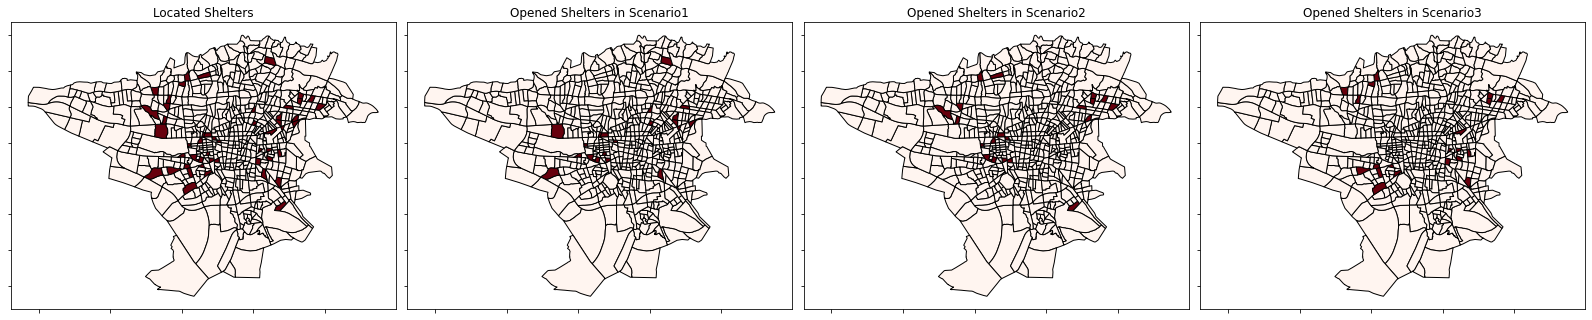

In [150]:
fig, axs = plt.subplots(figsize=(22,12), ncols=4,constrained_layout=True)

result.plot(column='located_shelters', edgecolor='black', cmap=plt.cm.Reds, ax=axs[0])
axs[0].set_title('Located Shelters')
for l in [1,2,3]:
    result.plot(column=f'opened_shelters_{l}', ax=axs[l], edgecolor='black', cmap=plt.cm.Reds)

for l in [1,2,3]:
    axs[l].set_title(f'Opened Shelters in Scenario{l}')
    
for ax in axs.flat:
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

### Zones affected and the people not finding shelters in each scenarios 

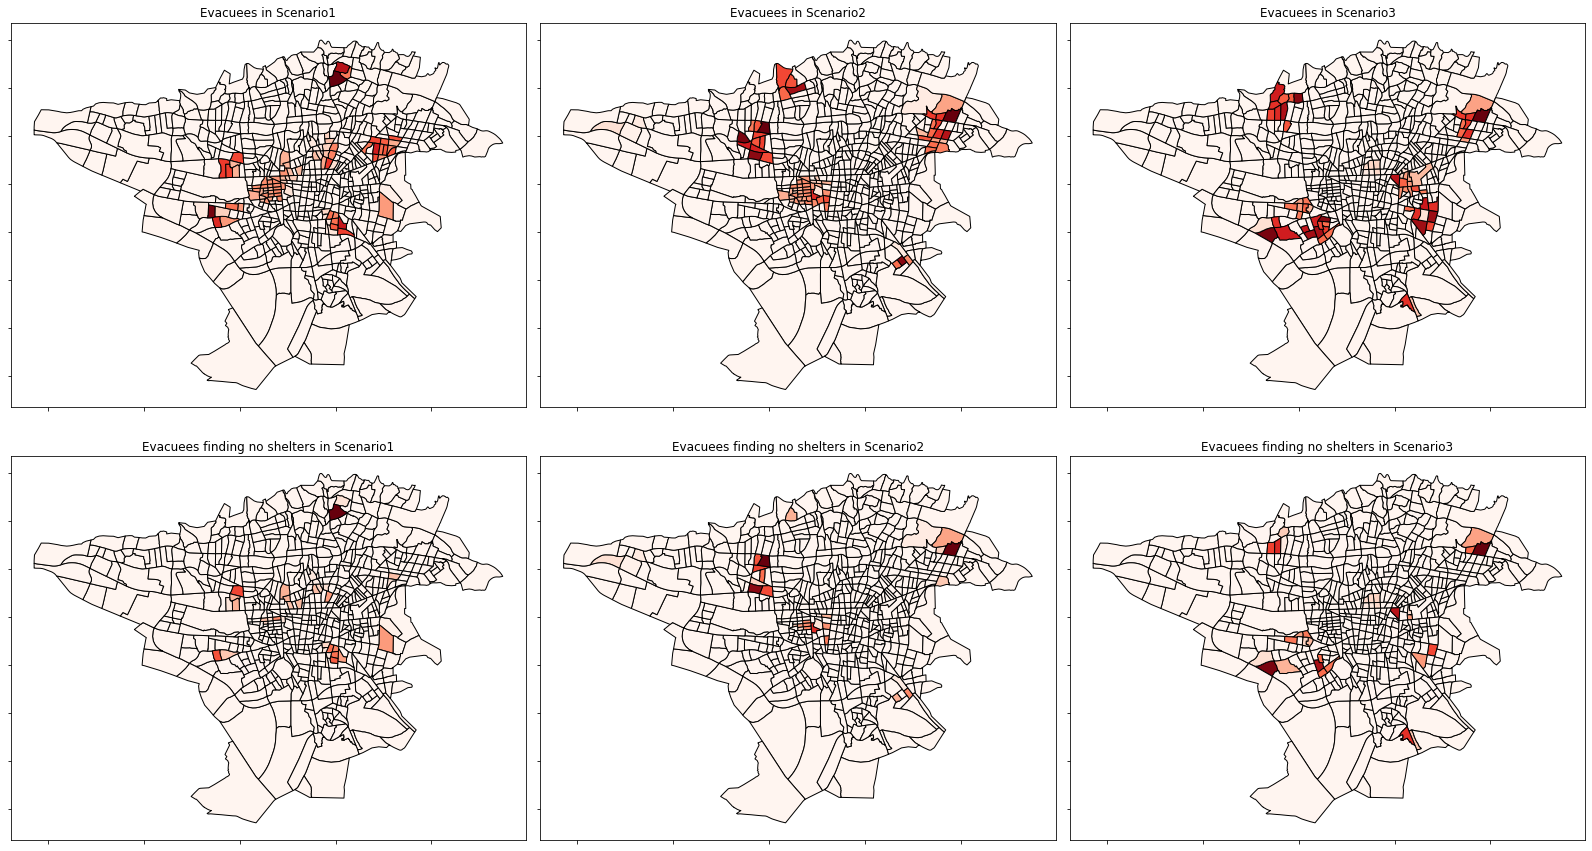

In [152]:
fig, axs = plt.subplots(figsize=(22,12), nrows=2, ncols=3, constrained_layout=True)

for l in [0,1,2]:
    result.plot(column=f'demand_{l+1}', ax=axs[0,l], edgecolor='black', cmap=plt.cm.Reds)
    axs[0,l].set_title(f'Evacuees in Scenario{l+1}')

for l in [0,1,2]:
    result.plot(column=f'unres_demand_{l+1}', ax=axs[1,l], edgecolor='black', cmap=plt.cm.Reds)
    axs[1,l].set_title(f'Evacuees finding no shelters in Scenario{l+1}')    

for ax in axs.flat:
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
plt.show()